# Setep 5: Machine Learning Model

<br>
In this step our Machine learning model will be created and its performance and accuracy will be evaluated using different parameters. Random Forest and Gradient-boosting were chosen to be used in the project

In [19]:
#Load Lemmatized Dataset from prevous steps
import pandas as pd

pd.set_option('display.max_rows', None, 'display.max_colwidth', 50)

fields = ['IE', 'NS', 'FT', 'PJ', 'Posts','Posts_Lemmatized', 'No_Words-Capital', 'No_WordsInQuotes', 'Avg_WordLength', 'UniqueWrd_vs_NoWrd', 'Sentiment_Score']

mbti_Dataset = pd.read_pickle('mbti_FE.pkl')
mbti_Dataset = mbti_Dataset.filter(fields)
mbti_Dataset.head()

,IE,NS,FT,PJ,Posts,Posts_Lemmatized,No_Words-Capital,No_WordsInQuotes,Avg_WordLength,UniqueWrd_vs_NoWrd,Sentiment_Score
0,I,N,F,J,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,"[, moment, sportscenter, top, ten, play, prank...",0.0,9.0,5.036496,0.647810,0.9805
1,E,N,T,P,'I'm finding the lack of me in these posts ver...,"[finding, lack, post, alarming, sex, boring, p...",1.0,26.0,4.494854,0.467410,0.9993
2,I,N,T,P,'Good one _____ https://www.youtube.com/wat...,"[good, one, course, say, know, blessing, curse...",2.0,15.0,5.003601,0.555822,0.9983
3,I,N,T,J,"'Dear INTP, I enjoyed our conversation the o...","[dear, enjoyed, conversation, day, esoteric, g...",3.0,28.0,4.774953,0.487759,0.9974
4,E,N,T,J,'You're fired.|||That's another silly misconce...,"[fired, another, silly, misconception, approac...",5.0,14.0,4.888083,0.518135,0.9396


## 5-1: Split our data into training and test

In this part we are splitting our Dataset into Training and Test dataset. Test size is 20%.

In [20]:
from sklearn.model_selection import train_test_split

fields = ['Posts_Lemmatized', 'No_Words-Capital', 'No_WordsInQuotes', 'Avg_WordLength', 'UniqueWrd_vs_NoWrd', 'Sentiment_Score']
X_train, X_test, Y_train, Y_test = train_test_split(mbti_Dataset[fields], mbti_Dataset[['IE' , 'NS', 'FT', 'PJ']], random_state=42, test_size=0.2)#20% of dataset is test set    

#Save Training and Test dataset in Picklet format.
X_train.to_pickle('X_train_fe.pkl')
X_test.to_pickle('X_test_fe.pkl')
Y_train.to_pickle('Y_train_fe.pkl')
Y_test.to_pickle('Y_test_fe.pkl')

Now training and test dataset will be converted to TFIDF, CountVectorizer and N-Grams(Same approad as step3 was used here). The result will be saved so it can be used in later steps. 

In [2]:
#Converting data to TFIDF and CountVectorizer. The result will be saved so it can be used in later steps. 
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from scipy import sparse
import pandas as pd


fields = ['No_Words-Capital', 'No_WordsInQuotes', 'Avg_WordLength', 'UniqueWrd_vs_NoWrd', 'Sentiment_Score']

def lemmatizing(text):
    """Lemmatizing the input text using WordNet and NLTK package"""
    NLTK_WNL = nltk.WordNetLemmatizer()
    text_Lem = [NLTK_WNL.lemmatize(word) for word in text]
    return(text_Lem)


def clean_and_load():
    """Delete all variables inside memory and load training and test dataset"""
    for name in dir():
        if not name.startswith('_'):
            del globals()[name]
    global X_train, X_test, Y_train, Y_test
    X_train = pd.read_pickle('X_train_fe.pkl')
    X_test = pd.read_pickle('X_test_fe.pkl')
    Y_train = pd.read_pickle('Y_train_fe.pkl')
    Y_test = pd.read_pickle('Y_test_fe.pkl')


##TFIDF
clean_and_load()
tfidf_vect = TfidfVectorizer(analyzer=lemmatizing)
tfidf_vect_fit = tfidf_vect.fit(X_train['Posts_Lemmatized'])

tfidf_train = tfidf_vect_fit.transform(X_train['Posts_Lemmatized'])
tfidf_test = tfidf_vect_fit.transform(X_test['Posts_Lemmatized'])


X_train_vec = pd.concat([X_train[fields].reset_index(drop=True),
                        pd.DataFrame(tfidf_train.toarray())], axis = 1)
X_train_vec.to_pickle('X_train_tfidf_fe.pkl')#Saving results

X_test_vec = pd.concat([X_test[fields].reset_index(drop=True),
                        pd.DataFrame(tfidf_test.toarray())], axis = 1)
X_test_vec.to_pickle('X_test_tfidf_fe.pkl')#Saving results


#CountVectorizer
clean_and_load()
count_vect = CountVectorizer(analyzer=lemmatizing)
count_vect_fit = count_vect.fit(X_train['Posts_Lemmatized'])

count_train = count_vect_fit.transform(X_train['Posts_Lemmatized'])
count_test = count_vect_fit.transform(X_test['Posts_Lemmatized'])

X_train_count = pd.concat([X_train[fields].reset_index(drop=True),
                  pd.DataFrame(count_train.toarray())], axis = 1)
X_train_count.to_pickle('X_train_count_fe.pkl')#Saving results

X_test_count = pd.concat([X_test[fields].reset_index(drop=True),
                  pd.DataFrame(count_test.toarray())], axis = 1)
X_test_count.to_pickle('X_test_count_fe.pkl')#Saving results


## 5-1: Random Forest Model
### 5-1-1: Explorering Random Forest with Holdout test set + grid-search
In this step, various parameters are being used on our train dataset to find the best parameter for our Random Forest model. (Number of estimator, Maximum depth)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', None, 'display.max_colwidth', 500)


def rfClassifier_GridSearch(X_test_set, X_train_set, Lable, n_est, depth, feature_type, is_print = True):
    """This function will get number of estimators and depth as input return  Precision, recall and Accuracy for a given dataset and lable"""
    if Lable == 'IE':
        s_Lable = 'I'
        predict_Lable = 'Introverts'
    elif Lable == 'NS':
        s_Lable = 'N'
        predict_Lable = 'Intuitives'
    elif Lable == 'FT':
        s_Lable = 'F'
        predict_Lable = 'Feelers'
    elif Lable == 'PJ':
        s_Lable = 'P'
        predict_Lable = 'Perceivers'

    rf = RandomForestClassifier(n_estimators=n_est, max_depth=depth ,n_jobs=-1)
    rf_model = rf.fit(X_train_set, Y_train[Lable])
    Y_pred = rf_model.predict(X_test_set)

    precision, recall, fscore, support = score(Y_test[Lable], Y_pred, pos_label=s_Lable, average='binary')
    if is_print:
        print('Being ' + predict_Lable + ' using ' + feature_type + ':'  ,
        'Estimators: {} / Max_Depth: {} --> Precision: {} / Recall: {} / Accuracy: {}'.format(
                                                        n_est,
                                                        depth,
                                                        round(precision, 3),
                                                        round(recall, 3), 
                                                        round((Y_pred==Y_test[Lable]).sum() / len(Y_pred),3)))
    return([predict_Lable, feature_type, n_est, depth, precision, recall, round((Y_pred==Y_test[Lable]).sum() / len(Y_pred),3)])


classes = ['IE' , 'NS', 'FT', 'PJ']
rf_result = []

Y_train = pd.read_pickle('Y_train_fe.pkl')
Y_test = pd.read_pickle('Y_test_fe.pkl')

#Nested loop to check different values on different features/classes to find the best parameters
for feature_type in ['TFIDF', 'CountVectorizer']:
    if feature_type == 'TFIDF':
        X_test_set = pd.read_pickle('X_test_tfidf_fe.pkl')
        X_train_set = pd.read_pickle('X_train_tfidf_fe.pkl')
    elif feature_type == 'CountVectorizer':
        X_test_set = pd.read_pickle('X_test_count_fe.pkl')
        X_train_set = pd.read_pickle('X_train_count_fe.pkl')
    for item in classes:
        for n_est in [10, 50, 100, 200, 500]:
            for depth in [5, 10, 20, 30, None]:
                rf_result.append(rfClassifier_GridSearch(X_test_set = X_test_set, X_train_set = X_train_set, Lable = item, n_est=n_est, depth=depth, feature_type=feature_type,is_print = False))
                pd.DataFrame(rf_result, columns= ['Type', 'Method', 'Estimators', 'Max_Depth', 'Precision', 'Recall', 'Accuracy']).to_csv('RF_Holdout_Result_fe.csv')

In [5]:
pd.DataFrame(rf_result, columns= ['Type', 'Method', 'Estimators', 'Max_Depth', 'Precision', 'Recall', 'Accuracy']).sort_values(['Accuracy'], ascending=False).groupby(['Method', 'Type']).head(1)

,Type,Method,Estimators,Max_Depth,Precision,Recall,Accuracy
29,Intuitives,TFIDF,10,NaN,0.859204,1.000000,0.859
127,Intuitives,CountVectorizer,10,20.0,0.858213,1.000000,0.858
104,Introverts,CountVectorizer,10,NaN,0.789192,0.982262,0.782
9,Introverts,TFIDF,50,NaN,0.780727,1.000000,0.781
174,Feelers,CountVectorizer,500,NaN,0.704202,0.894344,0.740
74,Feelers,TFIDF,500,NaN,0.703925,0.880470,0.735
84,Perceivers,TFIDF,50,NaN,0.649169,0.916510,0.644
189,Perceivers,CountVectorizer,100,NaN,0.632149,0.984991,0.639


Checking the result to find best parameters for our Grid Search:

In [6]:
from tabulate import tabulate

df = pd.read_csv('RF_Holdout_Result_fe.csv')[['Type', 'Method', 'Estimators', 'Max_Depth', 'Precision', 'Recall', 'Accuracy']]
print(df[df['Method'] == 'TFIDF'].sort_values(['Accuracy', 'Type'], ascending = False).groupby(['Type']).head(1).to_markdown(), '\n')
print(df[df['Method'] == 'CountVectorizer'].sort_values(['Accuracy', 'Type'], ascending = False).groupby(['Type']).head(1).to_markdown())

|    | Type       | Method   |   Estimators |   Max_Depth |   Precision |   Recall |   Accuracy |
|---:|:-----------|:---------|-------------:|------------:|------------:|---------:|-----------:|
| 29 | Intuitives | TFIDF    |           10 |         nan |    0.859204 | 1        |      0.859 |
|  9 | Introverts | TFIDF    |           50 |         nan |    0.780727 | 1        |      0.781 |
| 73 | Feelers    | TFIDF    |          500 |          30 |    0.701266 | 0.886873 |      0.735 |
| 84 | Perceivers | TFIDF    |           50 |         nan |    0.649169 | 0.91651  |      0.644 | 

|     | Type       | Method          |   Estimators |   Max_Depth |   Precision |   Recall |   Accuracy |
|----:|:-----------|:----------------|-------------:|------------:|------------:|---------:|-----------:|
| 125 | Intuitives | CountVectorizer |           10 |           5 |    0.858213 | 1        |      0.858 |
| 104 | Introverts | CountVectorizer |           10 |         nan |    0.789192 | 0.982262 |

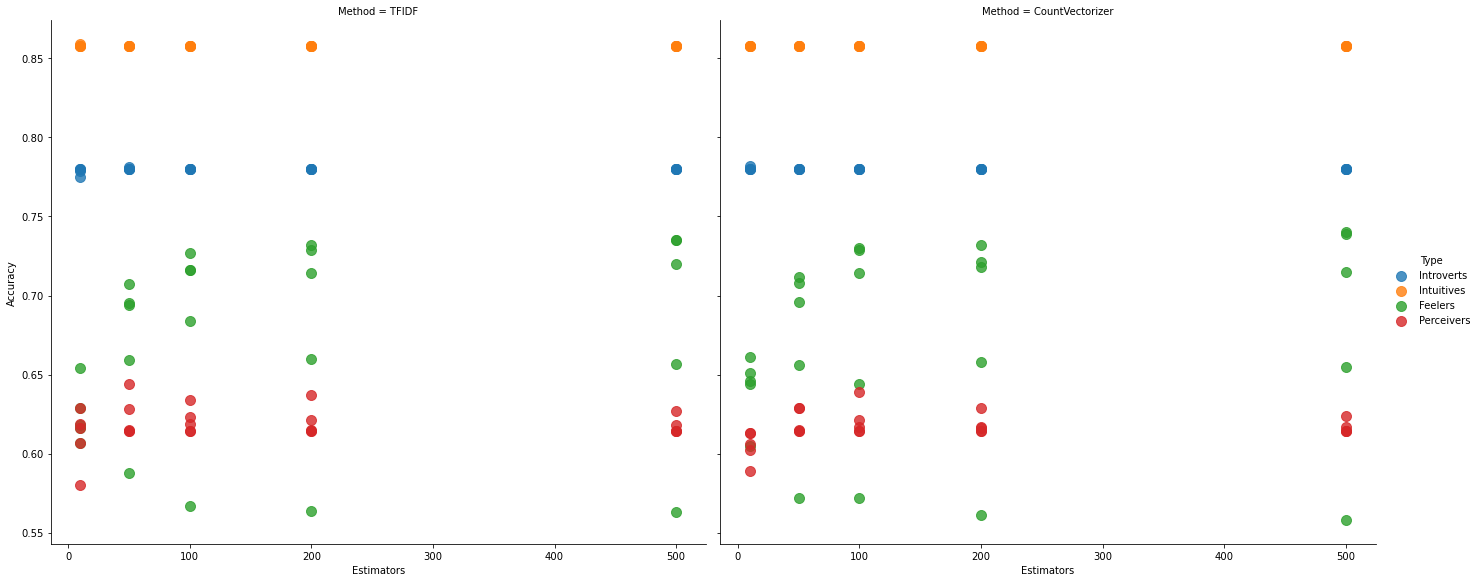

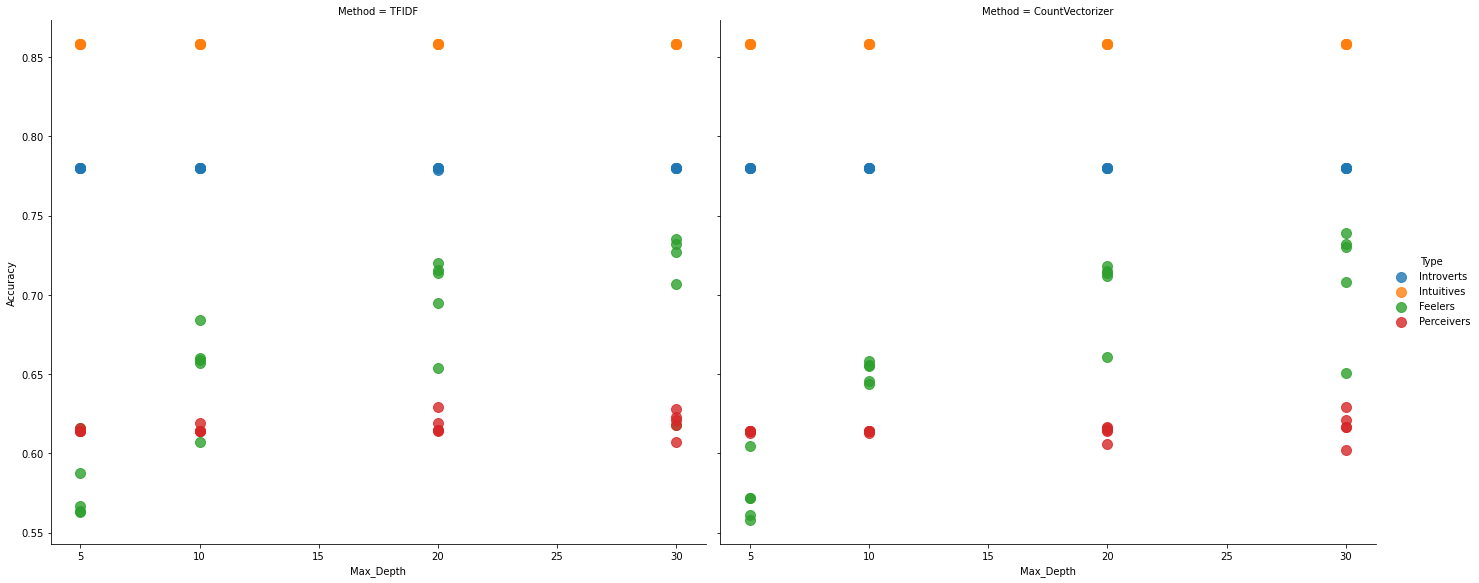

In [7]:
import seaborn as sns
from pandas import DataFrame

df = pd.read_csv('RF_Holdout_Result_fe.csv')

sns.lmplot(x='Estimators', y='Accuracy', data=df, hue='Type', fit_reg=False, aspect=1.2, height = 8, scatter_kws={"s": 100}, col = 'Method')
sns.lmplot(x='Max_Depth', y='Accuracy', data=df, hue='Type', fit_reg=False, aspect=1.2, height = 8, scatter_kws={"s": 100}, col = 'Method')

#### Based on the results , Max_Depth increases accuracy specially for Feelers and Perceivers groups. In general TFID is slightly bettrer. Therefor evaluation Random forest model using TFIDF and  Max_Depth as 5 and 30 and Non and also Number of estimators 500, 100 and 10.

### 5-1-2 : Train vectorizes on training set and use that to transform test set.

5 fold validation is being used here:

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd
#from scipy import sparse
import numpy as np

pd.set_option('display.max_colwidth', 500)


def RF_Evaluation(param, Lable, is_print = True):
    rf = RandomForestClassifier()
    gs = GridSearchCV(rf, param, cv=5, n_jobs = 2)#cv=5 means 5 folde validation
    gs_fit = gs.fit(X_train_set, Y_train[Lable])
    
    if is_print:
        print(pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending = False)[['param_max_depth',
        'param_n_estimators', 'std_test_score', 'mean_test_score', 'rank_test_score']][0:5])

    return(pd.DataFrame(gs_fit.cv_results_))



#Base on the results from previous steps
param = {'n_estimators' : [10, 50, 100, 500],
        'max_depth' : [5, 30, None]}

classes = ['IE' , 'NS', 'FT', 'PJ']
Y_train = pd.read_pickle('Y_train_fe.pkl')
rf_parm_result = []


for feature_type in ['CountVectorizer', 'TFIDF']:
    if feature_type == 'TFIDF':
        X_train_set = pd.read_pickle('X_train_tfidf_fe.pkl')
    elif feature_type == 'CountVectorizer':
        X_train_set = pd.read_pickle('X_train_count_fe.pkl')
    for item in classes:
        temp_DF = RF_Evaluation(param, Lable = item, is_print = False)
        temp_DF.insert(0, 'Feature', feature_type)
        temp_DF.insert(1, 'Class', item)
        rf_parm_result.append(temp_DF)
        pd.concat(rf_parm_result).to_csv('RF_Parm_Result_fe.csv')

pd.concat(rf_parm_result).to_csv('RF_Parm_Result_fe.csv')


In [26]:
df = pd.read_csv('RF_Parm_Result_fe.csv')
df = df[df['rank_test_score'] == 1]
print(df[['Feature', 'Class', 'param_max_depth', 'param_n_estimators', 'mean_test_score', 'rank_test_score']].sort_values(['mean_test_score', 'Class'], ascending = False).to_markdown(), '\n')

|    | Feature         | Class   |   param_max_depth |   param_n_estimators |   mean_test_score |   rank_test_score |
|---:|:----------------|:--------|------------------:|---------------------:|------------------:|------------------:|
| 68 | CountVectorizer | NS      |               nan |                   10 |          0.863256 |                 1 |
| 16 | TFIDF           | NS      |                30 |                   10 |          0.863112 |                 1 |
| 20 | TFIDF           | NS      |               nan |                   10 |          0.863112 |                 1 |
|  4 | TFIDF           | IE      |                30 |                   10 |          0.767867 |                 1 |
| 52 | CountVectorizer | IE      |                30 |                   10 |          0.767579 |                 1 |
| 83 | CountVectorizer | FT      |               nan |                  500 |          0.753746 |                 1 |
| 35 | TFIDF           | FT      |               nan |  

## 5-2: Gradient Boosting Model
### 5-2-1: Gradient Boosting with Holdout test set

In [21]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import numpy as np
from datetime import datetime


pd.set_option('display.max_rows', None, 'display.max_colwidth', 500)


def GBoosting_GridSearch(Lable, n_est, depth, lr, feature_type, is_print = True):
    if Lable == 'IE':
        s_Lable = 'I'
        predict_Lable = 'Introverts'
    elif Lable == 'NS':
        s_Lable = 'N'
        predict_Lable = 'Intuitives'
    elif Lable == 'FT':
        s_Lable = 'F'
        predict_Lable = 'Feelers'
    elif Lable == 'PJ':
        s_Lable = 'P'
        predict_Lable = 'Perceivers'

    gb = GradientBoostingClassifier(n_estimators=n_est, max_depth=depth , learning_rate=lr)
    gb_model = gb.fit(X_train_set, Y_train[Lable])
    Y_pred = gb_model.predict(X_test_set)

    precision, recall, fscore, support = score(Y_test[Lable], Y_pred, pos_label=s_Lable, average='binary')
    if is_print:
        print('Being ' + predict_Lable + ' using ' + feature_type + ': '  ,'Estimators: {} / Max_Depth: {} / Learning_Rate: {} --> Precision: {} / Recall: {} / Accuracy: {}'.format(
                                                        n_est,
                                                        depth,
                                                        lr,
                                                        round(precision, 3),
                                                        round(recall, 3), 
                                                        round((Y_pred==Y_test[Lable]).sum() / len(Y_pred),3)))
    return([predict_Lable, feature_type, n_est, depth, lr, precision, recall, round((Y_pred==Y_test[Lable]).sum() / len(Y_pred),3)])



classes = ['IE' , 'NS', 'FT', 'PJ']
gb_result = []

Y_train = pd.read_pickle('Y_train_fe.pkl')
Y_test = pd.read_pickle('Y_test_fe.pkl')



for feature_type in ['TFIDF', 'CountVectorizer']:
    if feature_type == 'TFIDF':
        X_test_set = pd.read_pickle('X_test_tfidf_fe.pkl')
        X_train_set = pd.read_pickle('X_train_tfidf_fe.pkl')
    elif feature_type == 'CountVectorizer':
        X_test_set = pd.read_pickle('X_test_count_fe.pkl')
        X_train_set = pd.read_pickle('X_train_count_fe.pkl')
    for item in classes:
        for n_est in [100, 150]:
            for depth in [3, 7]:
                for lr in [0.10]:
                    gb_result.append(GBoosting_GridSearch(Lable = item, n_est=n_est, depth=depth, lr = lr, feature_type=feature_type, is_print = False))
                    pd.DataFrame(gb_result, columns= ['Type', 'Method', 'Estimators', 'Max_Depth', 'Learning_Rate','Precision', 'Recall', 'Accuracy']).to_csv('GB_Holdout_Result-fe.csv')


In [22]:
from tabulate import tabulate

df = pd.read_csv('GB_Holdout_Result-fe.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
print(df.sort_values(['Accuracy', 'Type'], ascending = False).groupby(['Type']).head(3).to_markdown(), '\n')
#print(df[df['Method'] == 'CountVectorizer'].sort_values(['Accuracy', 'Type'], ascending = False).groupby(['Type']).head(1).to_markdown())

|    | Type       | Method          |   Estimators |   Max_Depth |   Learning_Rate |   Precision |   Recall |   Accuracy |
|---:|:-----------|:----------------|-------------:|------------:|----------------:|------------:|---------:|-----------:|
|  7 | Intuitives | TFIDF           |          150 |           7 |             0.1 |    0.882388 | 0.982539 |      0.873 |
| 20 | Intuitives | CountVectorizer |          100 |           3 |             0.1 |    0.876786 | 0.989255 |      0.871 |
|  6 | Intuitives | TFIDF           |          150 |           3 |             0.1 |    0.879735 | 0.982539 |      0.87  |
| 18 | Introverts | CountVectorizer |          150 |           3 |             0.1 |    0.845659 | 0.971914 |      0.84  |
| 16 | Introverts | CountVectorizer |          100 |           3 |             0.1 |    0.840282 | 0.968219 |      0.832 |
| 17 | Introverts | CountVectorizer |          100 |           7 |             0.1 |    0.837075 | 0.964523 |      0.826 |
| 27 | Feelers  

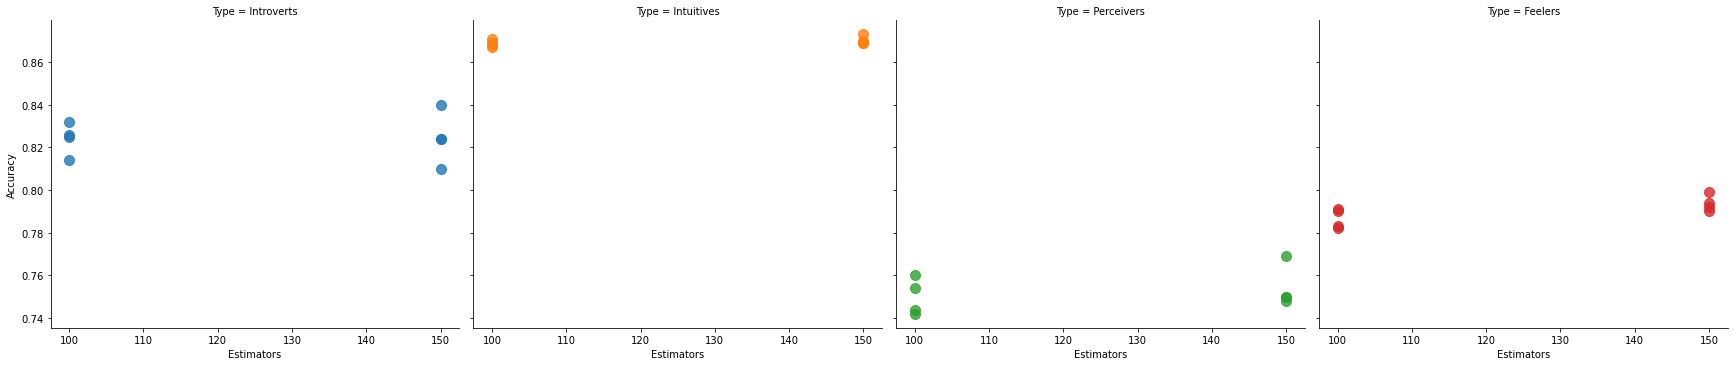

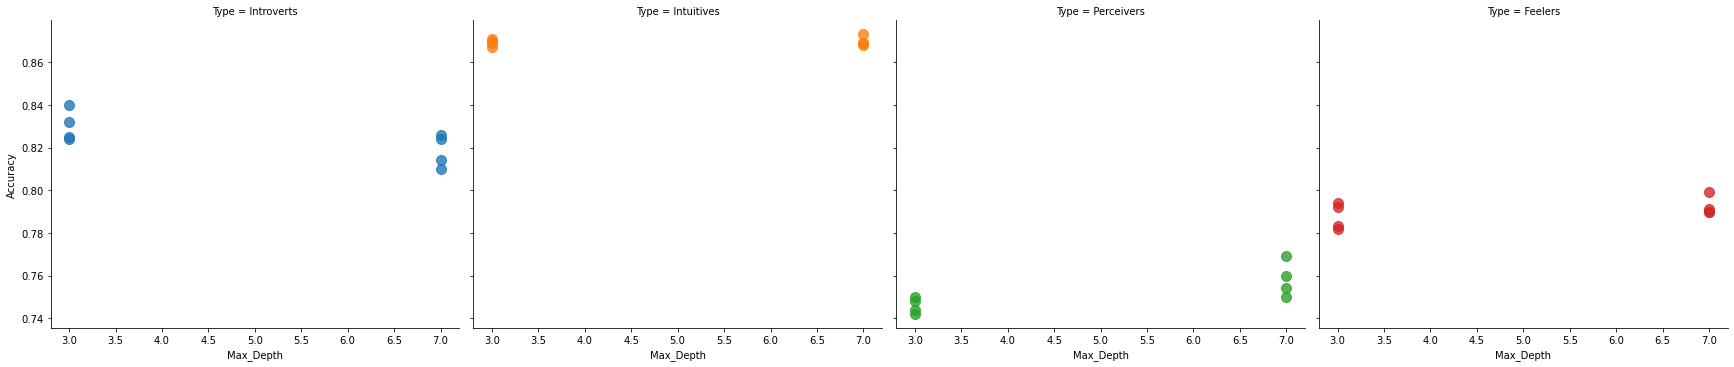

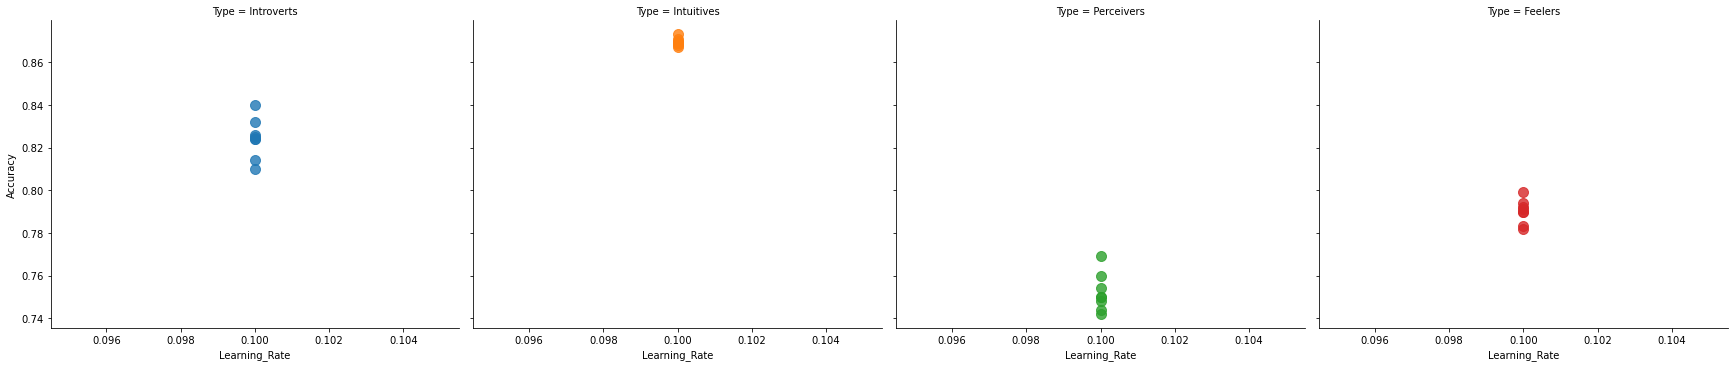

In [23]:
import seaborn as sns
from pandas import DataFrame

df = pd.read_csv('GB_Holdout_Result-fe.csv')

sns.lmplot(x='Estimators', y='Accuracy', data=df, hue='Type', fit_reg=False, aspect=1.2, height = 5, scatter_kws={"s": 100}, col = 'Type')
sns.lmplot(x='Max_Depth', y='Accuracy', data=df, hue='Type', fit_reg=False, aspect=1.2, height = 5, scatter_kws={"s": 100}, col = 'Type')
sns.lmplot(x='Learning_Rate', y='Accuracy', data=df, hue='Type', fit_reg=False, aspect=1.2, height = 5, scatter_kws={"s": 100}, col = 'Type')

### 5-2-2: Evaluation Gradient Boosting Model

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np

pd.set_option('display.max_colwidth', 500)


def GB_Evaluation(param, Lable, is_print = True):
    gb = GradientBoostingClassifier()
    gs = GridSearchCV(gb, param, cv=5)#cv=5 meand 5 folde validation
    gs_fit = gs.fit(X_train_set, Y_train[Lable])

    if is_print:
        print(pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending = False)[['param_max_depth', 
        'param_n_estimators', 'param_learning_rate','std_test_score', 'mean_test_score', 'rank_test_score']][0:5])

    return(pd.DataFrame(gs_fit.cv_results_))
  
param = {'n_estimators' : [150],
                'max_depth' : [7, 3],
                'learning_rate' : [0.1]}

classes = ['IE' , 'NS', 'FT', 'PJ']
Y_train = pd.read_pickle('Y_train_fe.pkl')
gb_parm_result = []


for feature_type in ['CountVectorizer']:#Only using CountVectorizer based on the result from previous steps
    X_train_set = pd.read_pickle('X_train_count_fe.pkl')
    for item in classes:
        temp_DF = GB_Evaluation(param, Lable = item, is_print = False)
        temp_DF.insert(0, 'Feature', feature_type)
        temp_DF.insert(1, 'Class', item)
        gb_parm_result.append(temp_DF)
        pd.concat(gb_parm_result).to_csv('GB_Parm_Result_fe-IE.csv')

In [30]:
import pandas as pd

df = pd.read_csv('GB_Parm_Result_fe.csv')
print(df[['Feature', 'Class', 'param_max_depth', 'param_n_estimators', 'param_learning_rate', 'mean_test_score', 'rank_test_score']]
    .sort_values(['rank_test_score'], ascending = True)
    .groupby(['Class']).head(1).to_markdown(), '\n')

|    | Feature         | Class   |   param_max_depth |   param_n_estimators |   param_learning_rate |   mean_test_score |   rank_test_score |
|---:|:----------------|:--------|------------------:|---------------------:|----------------------:|------------------:|------------------:|
|  0 | CountVectorizer | IE      |                 7 |                  150 |                   0.1 |          0.816859 |                 1 |
|  3 | CountVectorizer | NS      |                 3 |                  150 |                   0.1 |          0.878674 |                 1 |
|  5 | CountVectorizer | PJ      |                 3 |                  150 |                   0.1 |          0.748991 |                 1 |
|  7 | CountVectorizer | FT      |                 3 |                  150 |                   0.1 |          0.793516 |                 1 | 



## 5-3: Naive Bayes classifier
### 5-3-1: Gradient Boosting with Holdout test set

In [31]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', None, 'display.max_colwidth', 500)

def rfClassifier_GridSearch(X_test_set, X_train_set, Lable, feature_type, is_print = True):
    """This function will get number of estimators and depth as input return  Precision, recall and Accuracy for a given dataset and lable"""
    if Lable == 'IE':
        s_Lable = 'I'
        predict_Lable = 'Introverts'
    elif Lable == 'NS':
        s_Lable = 'N'
        predict_Lable = 'Intuitives'
    elif Lable == 'FT':
        s_Lable = 'F'
        predict_Lable = 'Feelers'
    elif Lable == 'PJ':
        s_Lable = 'P'
        predict_Lable = 'Perceivers'

    X_train_set = X_train_set.drop(['Sentiment_Score'], axis=1)
    X_test_set = X_test_set.drop(['Sentiment_Score'], axis=1)
    
    nb = MultinomialNB()
    nb_model = nb.fit(X_train_set, Y_train[Lable])
    Y_pred = nb_model.predict(X_test_set)
    
    precision, recall, fscore, support = score(Y_test[Lable], Y_pred, pos_label=s_Lable, average='binary')
    if is_print:
        print('Being ' + predict_Lable + ' using ' + feature_type + ':'  ,
        ' --> Precision: {} / Recall: {} / Accuracy: {}'.format(
                                                        round(precision, 3),
                                                        round(recall, 3), 
                                                        round((Y_pred==Y_test[Lable]).sum() / len(Y_pred),3)))
    return([predict_Lable, feature_type, precision, recall, round((Y_pred==Y_test[Lable]).sum() / len(Y_pred),3)])


classes = ['IE' , 'NS', 'FT', 'PJ']
rf_result = []

Y_train = pd.read_pickle('Y_train_fe.pkl')
Y_test = pd.read_pickle('Y_test_fe.pkl')

#Nested loop to check different values on different features/classes to find the best parameters
for feature_type in ['TFIDF', 'CountVectorizer']:
    if feature_type == 'TFIDF':
        X_test_set = pd.read_pickle('X_test_tfidf_fe.pkl')
        X_train_set = pd.read_pickle('X_train_tfidf_fe.pkl')
    elif feature_type == 'CountVectorizer':
        X_test_set = pd.read_pickle('X_test_count_fe.pkl')
        X_train_set = pd.read_pickle('X_train_count_fe.pkl')
    for item in classes:
        rf_result.append(rfClassifier_GridSearch(X_test_set = X_test_set, X_train_set = X_train_set, Lable = item, feature_type=feature_type, is_print = True))
        pd.DataFrame(rf_result, columns= ['Type', 'Method', 'Precision', 'Recall', 'Accuracy']).to_csv('NB_Holdout_Result_fe.csv')

Being Introverts using TFIDF:  --> Precision: 0.78 / Recall: 1.0 / Accuracy: 0.78
Being Intuitives using TFIDF:  --> Precision: 0.858 / Recall: 1.0 / Accuracy: 0.858
Being Feelers using TFIDF:  --> Precision: 0.542 / Recall: 0.999 / Accuracy: 0.543
Being Perceivers using TFIDF:  --> Precision: 0.614 / Recall: 1.0 / Accuracy: 0.614
Being Introverts using CountVectorizer:  --> Precision: 0.784 / Recall: 0.993 / Accuracy: 0.781
Being Intuitives using CountVectorizer:  --> Precision: 0.859 / Recall: 0.999 / Accuracy: 0.859
Being Feelers using CountVectorizer:  --> Precision: 0.765 / Recall: 0.866 / Accuracy: 0.784
Being Perceivers using CountVectorizer:  --> Precision: 0.685 / Recall: 0.91 / Accuracy: 0.687


## Final evaluation of models
### 1- Random Forest Classifier

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import time
import math

Y_train = pd.read_pickle('Y_train_fe.pkl')
Y_test = pd.read_pickle('Y_test_fe.pkl')
X_train_count = pd.read_pickle('X_train_count_fe.pkl')
X_test_count = pd.read_pickle('X_test_count_fe.pkl')

df = pd.read_csv('RF_Parm_Result_fe.csv')
df = df.sort_values(['rank_test_score'], ascending = True).groupby(['Class']).head(1)

def RF_Final_Eval(item):
    if item['Class'] == 'IE':
        Lable, s_Lable, predict_Lable = 'IE', 'I', 'Introverts'
 
    elif item['Class'] == 'NS':
        Lable, s_Lable, predict_Lable = 'NS', 'N', 'Intuitives'

    elif item['Class'] == 'FT':
        Lable, s_Lable, predict_Lable = 'FT','F', 'Feelers'

    elif item['Class'] == 'PJ':
        Lable, s_Lable, predict_Lable = 'PJ','P', 'Perceivers'
    
    if math.isnan(item['param_max_depth']):
        item['param_max_depth'] = None

    rf = RandomForestClassifier(n_estimators=item['param_n_estimators'], max_depth=item['param_max_depth'], n_jobs=-1)

    start = time.time()
    rf_model = rf.fit(X_train_count, Y_train[Lable])
    end = time.time()
    fit_time = (end - start)

    start = time.time()
    Y_pred = rf_model.predict(X_test_count)
    end = time.time()
    pred_time = (end - start)

    precision, recall, fscore, train_support = score(Y_test[Lable], Y_pred, pos_label=s_Lable, average='binary')

    print('{} --> Fit time: {} / Predict time: {} --> Estimator {} / Max_Depth {} --> Precision: {} / Recall: {} / Accuracy: {}'.format(
                                                    predict_Lable,
                                                    round(fit_time, 3),
                                                    round(pred_time, 3),
                                                    item['param_n_estimators'],
                                                    item['param_max_depth'],
                                                    round(precision, 3),
                                                    round(recall, 3), 
                                                    round((Y_pred==Y_test[Lable]).sum() / len(Y_pred),3)))


for index, item in df.iterrows():
    RF_Final_Eval(item)


Intuitives --> Fit time: 22.561 / Predict time: 2.122 --> Estimator 10 / Max_Depth None --> Precision: 0.858 / Recall: 1.0 / Accuracy: 0.858
Introverts --> Fit time: 28.255 / Predict time: 2.002 --> Estimator 10 / Max_Depth 30.0 --> Precision: 0.782 / Recall: 0.997 / Accuracy: 0.78
Feelers --> Fit time: 149.833 / Predict time: 2.779 --> Estimator 500 / Max_Depth None --> Precision: 0.709 / Recall: 0.89 / Accuracy: 0.743
Perceivers --> Fit time: 47.474 / Predict time: 2.642 --> Estimator 100 / Max_Depth None --> Precision: 0.634 / Recall: 0.979 / Accuracy: 0.64


### 2- Gradient Boosting Classifier

In [2]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import time
import pandas as pd
import numpy as np
import math

classes = ['IE' , 'NS', 'FT', 'PJ']
Y_train = pd.read_pickle('Y_train_fe.pkl')
Y_test = pd.read_pickle('Y_test_fe.pkl')
X_train_count = pd.read_pickle('X_train_count_fe.pkl')
X_test_count = pd.read_pickle('X_test_count_fe.pkl')

df = pd.read_csv('GB_Parm_Result_fe.csv')
df = df.sort_values(['rank_test_score'], ascending = True).groupby(['Class']).head(1)

def GB_Final_Eval(item):
    if item['Class'] == 'IE':
        Lable, s_Lable, predict_Lable = 'IE', 'I', 'Introverts'
 
    elif item['Class'] == 'NS':
        Lable, s_Lable, predict_Lable = 'NS', 'N', 'Intuitives'

    elif item['Class'] == 'FT':
        Lable, s_Lable, predict_Lable = 'FT','F', 'Feelers'

    elif item['Class'] == 'PJ':
        Lable, s_Lable, predict_Lable = 'PJ','P', 'Perceivers'
    
    if math.isnan(item['param_max_depth']):
        item['param_max_depth'] = None

    gb = GradientBoostingClassifier(n_estimators=item['param_n_estimators'], max_depth=item['param_max_depth'], learning_rate=item['param_learning_rate'])

    start = time.time()
    gb_model = gb.fit(X_train_count,Y_train[Lable])
    end = time.time()
    fit_time = (end - start)

    start = time.time()
    Y_pred = gb_model.predict(X_test_count)
    end = time.time()
    pred_time = (end - start)


    precision, recall, fscore, train_support = score(Y_test[Lable], Y_pred, pos_label=s_Lable, average='binary')

    print('{} --> Fit time: {} / Predict time: {} --> Estimator {} / Max_Depth {} Learning_Rate {} --> Precision: {} / Recall: {} / Accuracy: {}'.format(
                                                    predict_Lable,
                                                    round(fit_time, 3),
                                                    round(pred_time, 3),
                                                    item['param_n_estimators'],
                                                    item['param_max_depth'],
                                                    item['param_learning_rate'],
                                                    round(precision, 3),
                                                    round(recall, 3), 
                                                    round((Y_pred==Y_test[Lable]).sum() / len(Y_pred),3)))
    
for index, item in df.iterrows():
    GB_Final_Eval(item)
                                                        

Introverts --> Fit time: 3988.485 / Predict time: 5.663 --> Estimator 150 / Max_Depth 7 Learning_Rate 0.1 --> Precision: 0.839 / Recall: 0.964 / Accuracy: 0.827
Intuitives --> Fit time: 1812.338 / Predict time: 5.804 --> Estimator 150 / Max_Depth 3 Learning_Rate 0.1 --> Precision: 0.877 / Recall: 0.989 / Accuracy: 0.871
Perceivers --> Fit time: 1826.955 / Predict time: 5.721 --> Estimator 150 / Max_Depth 3 Learning_Rate 0.1 --> Precision: 0.75 / Recall: 0.893 / Accuracy: 0.751
Feelers --> Fit time: 1863.441 / Predict time: 5.766 --> Estimator 150 / Max_Depth 3 Learning_Rate 0.1 --> Precision: 0.794 / Recall: 0.832 / Accuracy: 0.793


### 3- Naive Bayes classifier

In [5]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import time
import pandas as pd
import numpy as np
import math
from sklearn.naive_bayes import MultinomialNB

classes = ['IE' , 'NS', 'FT', 'PJ']
Y_train = pd.read_pickle('Y_train_fe.pkl')
Y_test = pd.read_pickle('Y_test_fe.pkl')
X_train_count = pd.read_pickle('X_train_count_fe.pkl')
X_test_count = pd.read_pickle('X_test_count_fe.pkl')
X_train_count = X_train_count.drop(['Sentiment_Score'], axis=1)
X_test_count = X_test_count.drop(['Sentiment_Score'], axis=1)

def NB_Final_Eval(lable):
    if lable == 'IE':
        s_Lable, predict_Lable = 'I', 'Introverts'
 
    elif lable == 'NS':
        s_Lable, predict_Lable = 'N', 'Intuitives'

    elif lable == 'FT':
        s_Lable, predict_Lable = 'F', 'Feelers'

    elif lable == 'PJ':
        s_Lable, predict_Lable = 'P', 'Perceivers'

    nb = MultinomialNB()

    start = time.time()
    nb_model = nb.fit(X_train_count, Y_train[lable])
    end = time.time()
    fit_time = (end - start)

    start = time.time()
    Y_pred = nb_model.predict(X_test_count)
    end = time.time()
    pred_time = (end - start)


    precision, recall, fscore, train_support = score(Y_test[lable], Y_pred, pos_label=s_Lable, average='binary')

    print('{} --> Fit time: {} / Predict time: {} --> Precision: {} / Recall: {} / Accuracy: {}'.format(
                                                    predict_Lable,
                                                    round(fit_time, 3),
                                                    round(pred_time, 3),
                                                    round(precision, 3),
                                                    round(recall, 3), 
                                                    round((Y_pred==Y_test[lable]).sum() / len(Y_pred),3)))
    
for lable in classes:
    NB_Final_Eval(lable)
                                                        

Introverts --> Fit time: 10.008 / Predict time: 2.31 --> Precision: 0.784 / Recall: 0.993 / Accuracy: 0.781
Intuitives --> Fit time: 18.62 / Predict time: 1.949 --> Precision: 0.859 / Recall: 0.999 / Accuracy: 0.859
Feelers --> Fit time: 9.331 / Predict time: 1.809 --> Precision: 0.765 / Recall: 0.866 / Accuracy: 0.784
Perceivers --> Fit time: 12.976 / Predict time: 1.792 --> Precision: 0.685 / Recall: 0.91 / Accuracy: 0.687


## Final table to compair Random Forest, Gradient Boosting and Naive Bayes models

| Model             | Type         | Fit_Time | Predict_Time | Percision | Recall | Accuracy |
|-------------------|--------------|----------|--------------|-----------|--------|----------|
| Random Forest     | Intuitives   | 22.561   | 2.122        | 0.858     | 1.0    | 0.858    |
| Gradient Boosting | Intuitives   | 1812.338 | 5.804        | 0.877     | 0.989  | 0.871    |
| Naive Bayes       | Intuitives   | 18.62    | 1.949        | 0.859     | 0.999  | 0.859    |
|-------------------|--------------|----------|--------------|-----------|--------|----------|
| Random Forest     | Introverts   | 28.255   | 2.002        | 0.782     | 0.997  | 0.78     |
| Gradient Boosting | Introverts   | 3988.485 | 5.663        | 0.839     | 0.964  | 0.827    |
| Naive Bayes       | Introverts   | 10.008   | 2.31         | 0.784     | 0.993  | 0.781    |
|-------------------|--------------|----------|--------------|-----------|--------|----------|
| Random Forest     | Feelers      | 149.833  | 2.779        | 0.709     | 0.89   | 0.743    |
| Gradient Boosting | Feelers      | 1863.441 | 5.766        | 0.794     | 0.832  | 0.793    |
| Naive Bayes       | Feelers      | 9.331    | 1.809        | 0.765     | 0.866  | 0.784    |
|-------------------|--------------|----------|--------------|-----------|--------|----------|
| Random Forest     | Perceivers   | 47.474   | 2.642        | 0.634     | 0.979  | 0.64     |
| Gradient Boosting | Perceivers   | 1826.955 | 5.721        | 0.75      | 0.893  | 0.751    |
| Naive Bayes       | Perceivers   | 12.976   | 1.792        | 0.685     | 0.91   | 0.687    |

GBoosting has a higher accuracy and significantly higher fitting time in comparison to Random Forest and Naive Bayes. Since the predicted time for GBoosting is slightly higher, but not significantly different, we are going to build our model once for this project. This model will be used to predict Twitter users' personality types.